<a href="https://colab.research.google.com/github/SYKIM5396/Airline_Satisfaction/blob/main/Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!pip install --upgrade xgboost
!pip install --upgrade lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline
plt.rcParams["figure.dpi"] = 144

import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")


데이터 불러오기

In [3]:
#데이터셋 불러오기
train = pd.read_csv('https://raw.githubusercontent.com/SYKIM5396/Airline_Satisfaction/main/train_processed.csv')
test = pd.read_csv('https://raw.githubusercontent.com/SYKIM5396/Airline_Satisfaction/main/test_processed.csv')

# 3.다양한 모델 설계 및 비교

데이터 분리

In [4]:
target = 'satisfaction'

train, val = train_test_split(
    train, train_size=0.80, test_size=0.20, stratify=train[target], random_state=53)

X_train, y_train = train.drop(columns=target), train[target]
X_val, y_val = val.drop(columns=target), val[target]
X_test, y_test = test.drop(columns=target), test[target]

## 기준모델 선정

기준모델은 타겟의 최빈 클래스로 설정합니다.

In [5]:
def eval_models(y_pred, y_pred_proba, y_real=y_val) :
    accuracy = accuracy_score(y_real, y_pred)
    precision = precision_score(y_real, y_pred)
    recall = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    print(f'accuracy : {accuracy.round(2)}')
    print(f'precision : {precision.round(2)}')
    print(f'recall : {recall.round(2)}')
    print(f'f1 : {f1.round(2)}')
    print(f"auc score : {auc.round(3)}")

    return accuracy, precision, recall, f1, auc

In [6]:
base = y_train.mode()[0]
baseline = len(y_val) * [base]

eval_models(baseline,baseline);

accuracy : 0.57
precision : 0.0
recall : 0.0
f1 : 0.0
auc score : 0.5


## Logistic Regression

In [7]:
# 수치형 특성만 스케일링
sclaer = StandardScaler()
num_cols = ['Age','Flight_Distance','Average_delay','Overall_Rating']

X_train_scaled, X_val_scaled, X_test_scaled = X_train.copy(), X_val.copy(), X_test.copy()

scaler = StandardScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val_scaled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])

In [8]:
nominal_cols = ['Gender', 'Customer_Type', 'Type_of_Travel', 'Class']

Cs = np.power(10.0, np.arange(-10, 10))

pire_LR_CV = make_pipeline(
        OneHotEncoder(use_cat_names=True, cols = nominal_cols),
        LogisticRegressionCV(Cs=Cs, cv=5, max_iter=1000,scoring="roc_auc", random_state=53)
            )
pire_LR_CV.fit(X_train_scaled, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Gender', 'Customer_Type',
                                     'Type_of_Travel', 'Class'],
                               use_cat_names=True)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09]),
                                      cv=5, max_iter=1000, random_state=53,
                                      scoring='roc_auc'))])

In [9]:
pire_LR_CV.named_steps['logisticregressioncv'].C_

array([0.1])

In [10]:
y_pred_LR = pire_LR_CV.predict(X_val_scaled)
y_pred_proba_LR = pire_LR_CV.predict_proba(X_val_scaled)[:,1]

print("훈련 auc ", pire_LR_CV.score(X_train_scaled, y_train))
eval_models(y_pred_LR,y_pred_proba_LR)

훈련 auc  0.9267063509843627
accuracy : 0.87
precision : 0.87
recall : 0.83
f1 : 0.85
auc score : 0.926


(0.8736345700399404,
 0.8735214896357887,
 0.828317601332593,
 0.8503191974464204,
 0.9260831467421481)

In [11]:
#로지스틱 회귀모델의 회귀계수 확인
pd.Series(pire_LR_CV.named_steps['logisticregressioncv'].coef_[0], pire_LR_CV.named_steps['logisticregressioncv'].feature_names_in_).sort_values(ascending=False)

Type_of_Travel_Business travel       1.341160
Customer_Type_Loyal Customer         0.989168
Online_boarding                      0.586131
Class_Business                       0.514839
Inflight_wifi_service                0.359705
Checkin_service                      0.300352
On-board_service                     0.275721
Overall_Rating                       0.257205
Leg_room_service                     0.227444
Cleanliness                          0.186282
Baggage_handling                     0.117459
Inflight_service                     0.077813
Inflight_entertainment               0.045627
Seat_comfort                         0.038863
Gender_Male                          0.011629
Gate_location                        0.011306
Flight_Distance                      0.000151
Gender_Female                       -0.023500
Food_and_drink                      -0.053405
Age                                 -0.113575
Departure/Arrival_time_convenient   -0.156119
Ease_of_Online_booking            

## RandomForest

In [12]:
mapping = [{'col': 'Gender', 'mapping': {'Female' : 1,  'Male' : 2,  None :-2}},
 {'col': 'Customer_Type', 'mapping': {'disloyal Customer' :1, 'Loyal Customer' : 2,  None :-2}},
 {'col': 'Type_of_Travel', 'mapping': {'Personal Travel' :   1 ,  'Business travel' :  2, None :-2}},
 {'col': 'Class', 'mapping': {'Eco':1, 'Eco Plus' : 2 ,'Business':3,  None :-2}}
]

In [41]:
params = {'randomforestclassifier__max_depth': np.arange(3, 15, 2),
               'randomforestclassifier__min_samples_split': [2, 4, 8, 16],
               'randomforestclassifier__min_samples_leaf': [1, 2, 4]
               }

In [42]:
pipe_rf = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        RandomForestClassifier(random_state=53,
                               oob_score=False, 
                               n_estimators=100,
                               n_jobs=-1)
        )

rf_random = RandomizedSearchCV(pipe_rf, param_distributions = params, scoring="roc_auc", n_iter = 10, cv = 5, verbose=3, random_state=53)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.988 total time=   6.3s
[CV 2/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.988 total time=   4.9s
[CV 3/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.987 total time=   5.0s
[CV 4/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.987 total time=   4.9s
[CV 5/5] END randomforestclassifier__max_depth=9, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=16;, score=0.987 total time=   5.0s
[CV 1/5] END randomforestclassifier__max_depth=3, randomforestclassifier__min_s

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(mapping=[{'col': 'Gender',
                                                                       'mapping': {None: -2,
                                                                                   'Female': 1,
                                                                                   'Male': 2}},
                                                                      {'col': 'Customer_Type',
                                                                       'mapping': {None: -2,
                                                                                   'Loyal Customer': 2,
                                                                                   'disloyal Customer': 1}},
                                                                      {'col': 'Type_of_Travel',
                                         

In [43]:
rf_random.best_params_

{'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_depth': 13}

In [44]:
y_pred_rf = rf_random.best_estimator_.predict(X_val)
y_pred_proba_rf = rf_random.best_estimator_.predict_proba(X_val)[:,1]

print("훈련 auc ", rf_random.best_estimator_.score(X_train, y_train))
eval_models(y_pred_rf,y_pred_proba_rf)

훈련 auc  0.9620321691950483
accuracy : 0.95
precision : 0.96
recall : 0.93
f1 : 0.95
auc score : 0.992


(0.9539964390549059,
 0.9603111060276793,
 0.9323709050527484,
 0.9461347757493801,
 0.9919328105762499)

## LGBMClassifier

In [28]:
params = {'lgbmclassifier__max_depth': np.arange(-1, 15, 4),
            'lgbmclassifier__min_child_weight': [2, 4, 8, 16],
            'lgbmclassifier__n_estimators' : np.arange(100, 1000, 100)
               }

In [29]:
pipe_lgbm = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        LGBMClassifier(random_state=53,
                       learning_rate=0.1,                              
                               n_jobs=-1)
        )

lgbm_random = RandomizedSearchCV(pipe_lgbm, param_distributions = params, scoring="roc_auc", n_iter = 10, cv = 5, verbose=3, random_state=53)
lgbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.995 total time=   9.0s
[CV 2/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.995 total time=   7.5s
[CV 3/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.995 total time=   7.6s
[CV 4/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.995 total time=   7.6s
[CV 5/5] END lgbmclassifier__max_depth=-1, lgbmclassifier__min_child_weight=2, lgbmclassifier__n_estimators=900;, score=0.995 total time=   7.7s
[CV 1/5] END lgbmclassifier__max_depth=11, lgbmclassifier__min_child_weight=8, lgbmclassifier__n_estimators=600;, score=0.995 total time=   5.7s
[CV 2/5] END lgbmclassifier__max_depth=11, lgbmclassifier__min_child_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(mapping=[{'col': 'Gender',
                                                                       'mapping': {None: -2,
                                                                                   'Female': 1,
                                                                                   'Male': 2}},
                                                                      {'col': 'Customer_Type',
                                                                       'mapping': {None: -2,
                                                                                   'Loyal Customer': 2,
                                                                                   'disloyal Customer': 1}},
                                                                      {'col': 'Type_of_Travel',
                                         

In [30]:
lgbm_random.best_params_

{'lgbmclassifier__n_estimators': 200,
 'lgbmclassifier__min_child_weight': 4,
 'lgbmclassifier__max_depth': 11}

In [31]:
y_pred_lgbm = lgbm_random.best_estimator_.predict(X_val)
y_pred_proba_lgbm = lgbm_random.best_estimator_.predict_proba(X_val)[:,1]

print("훈련 auc ", lgbm_random.best_estimator_.score(X_train, y_train))
eval_models(y_pred_lgbm,y_pred_proba_lgbm)

훈련 auc  0.9715000661670056
accuracy : 0.96
precision : 0.98
recall : 0.94
f1 : 0.96
auc score : 0.996


(0.9645349116981858,
 0.9762672811059908,
 0.9410327595780122,
 0.9583262651964942,
 0.9955792128618159)

## XGBClassifier

In [33]:
params={'xgbclassifier__max_depth': np.arange(3, 15, 2),
        "xgbclassifier__min_child_weight" : [4,8,16],
        "xgbclassifier__n_estimators" : np.arange(100, 1000, 100)
    }

In [37]:
pipe_xgb = make_pipeline(
        OrdinalEncoder(mapping=mapping),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",
            random_state=53,
            learning_rate=0.1,
            n_jobs=-1,
            ))
        
xgb_random = RandomizedSearchCV(pipe_xgb, param_distributions = params, scoring="roc_auc", n_iter = 10, cv = 5, verbose=3, random_state=53)
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=16, xgbclassifier__n_estimators=400;, score=0.995 total time=  45.8s
[CV 2/5] END xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=16, xgbclassifier__n_estimators=400;, score=0.995 total time=  47.6s
[CV 3/5] END xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=16, xgbclassifier__n_estimators=400;, score=0.995 total time=  45.0s
[CV 4/5] END xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=16, xgbclassifier__n_estimators=400;, score=0.995 total time=  45.1s
[CV 5/5] END xgbclassifier__max_depth=9, xgbclassifier__min_child_weight=16, xgbclassifier__n_estimators=400;, score=0.994 total time=  45.2s
[CV 1/5] END xgbclassifier__max_depth=13, xgbclassifier__min_child_weight=16, xgbclassifier__n_estimators=200;, score=0.995 total time=  32.9s
[CV 2/5] END xgbclassifier__max_depth=13, xgbclassifier__min_child_weight=16, xgbclass

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(mapping=[{'col': 'Gender',
                                                                       'mapping': {None: -2,
                                                                                   'Female': 1,
                                                                                   'Male': 2}},
                                                                      {'col': 'Customer_Type',
                                                                       'mapping': {None: -2,
                                                                                   'Loyal Customer': 2,
                                                                                   'disloyal Customer': 1}},
                                                                      {'col': 'Type_of_Travel',
                                         

In [38]:
xgb_random.best_params_

{'xgbclassifier__n_estimators': 200,
 'xgbclassifier__min_child_weight': 4,
 'xgbclassifier__max_depth': 13}

In [45]:
y_pred_xgb = xgb_random.best_estimator_.predict(X_val)
y_pred_proba_xgb = xgb_random.best_estimator_.predict_proba(X_val)[:,1]

print("훈련 auc ", xgb_random.best_estimator_.score(X_train, y_train))
eval_models(y_pred_xgb,y_pred_proba_xgb)

훈련 auc  0.9969563177459909
accuracy : 0.96
precision : 0.97
recall : 0.94
f1 : 0.96
auc score : 0.995


(0.9645830325778355,
 0.9741942883358183,
 0.9432537479178235,
 0.9584743850146695,
 0.9954684557793979)

## 모델 비교

In [51]:
comparison_metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'f1', 'auc'], columns=['Base','Logistic', 'Randomforest', 'LGBM', 'XGBoost'])
comparison_metrics['Base'] = eval_models(baseline,baseline)
comparison_metrics['Logistic'] =eval_models(y_pred_LR,y_pred_proba_LR)
comparison_metrics['Randomforest'] =eval_models(y_pred_rf,y_pred_proba_rf)
comparison_metrics['LGBM'] =eval_models(y_pred_lgbm,y_pred_proba_lgbm)
comparison_metrics['XGBoost'] =eval_models(y_pred_xgb,y_pred_proba_xgb)
comparison_metrics.round(3)

accuracy : 0.57
precision : 0.0
recall : 0.0
f1 : 0.0
auc score : 0.5
accuracy : 0.87
precision : 0.87
recall : 0.83
f1 : 0.85
auc score : 0.926
accuracy : 0.95
precision : 0.96
recall : 0.93
f1 : 0.95
auc score : 0.992
accuracy : 0.96
precision : 0.98
recall : 0.94
f1 : 0.96
auc score : 0.996
accuracy : 0.96
precision : 0.97
recall : 0.94
f1 : 0.96
auc score : 0.995


,Base,Logistic,Randomforest,LGBM,XGBoost
accuracy,0.567,0.874,0.954,0.965,0.965
precision,0.000,0.874,0.960,0.976,0.974
recall,0.000,0.828,0.932,0.941,0.943
f1,0.000,0.850,0.946,0.958,0.958
auc,0.500,0.926,0.992,0.996,0.995


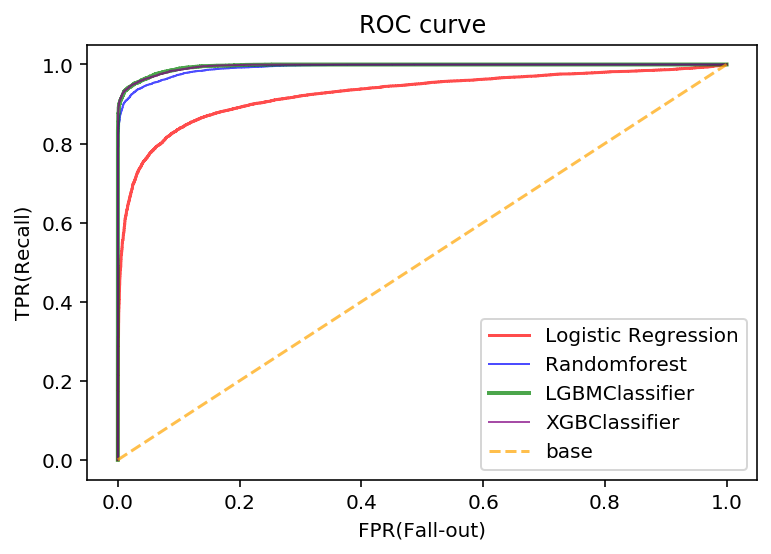

In [62]:

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_LR)
plt.plot(fpr, tpr, label='Logistic Regression', color = 'red',alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_rf)
plt.plot(fpr, tpr, label='Randomforest', color = 'blue',lw=1,alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_lgbm)
plt.plot(fpr, tpr, label='LGBMClassifier', color = 'green',lw=2,alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,y_pred_proba_xgb)
plt.plot(fpr, tpr, label='XGBClassifier', color = 'purple',lw=1 ,alpha=0.7)

fpr, tpr, thresholds = roc_curve(y_val,baseline)
plt.plot(fpr, tpr, label='base',linestyle='--', color = 'orange',alpha=0.7)

plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.legend();

성능과 모델 속도 등 여러가지 요소에서 모두 뛰어난 모습을 보이는 LGBMClassifier를 채용한다.